# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scipy.io
import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
l1_lambda=1

# 2. Loading data

In [3]:
data_path="./Dataset/USPS.mat"
Data = scipy.io.loadmat(data_path)

data_arr=Data['X'].astype('float32')
label_arr=Data['Y'][:, 0]-1

#label_arr=to_categorical(label_arr_)

In [4]:
C_train_x,C_test_x,C_train_y,C_test_y= train_test_split(data_arr,label_arr,test_size=0.2,random_state=seed)
x_train,x_validate,y_train,y_validate= train_test_split(C_train_x,C_train_y,test_size=0.1,random_state=seed)

print('Shape of C_train_x: ' + str(C_train_x.shape)) 
print('Shape of C_train_y: ' + str(C_train_y.shape)) 
print('Shape of C_test_x: ' + str(C_test_x.shape)) 
print('Shape of C_test_y: ' + str(C_test_y.shape)) 

x_test=C_test_x
y_test=C_test_y

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape)) 
print('Shape of x_validate: ' + str(x_validate.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))
print('Shape of y_validate: ' + str(y_validate.shape))

'''
y_train_onehot = to_categorical(y_train_)
y_validate_onehot = to_categorical(y_validate_)
y_test_onehot = to_categorical(C_test_y)
'''

Shape of C_train_x: (7438, 256)
Shape of C_train_y: (7438,)
Shape of C_test_x: (1860, 256)
Shape of C_test_y: (1860,)
Shape of x_train: (6694, 256)
Shape of x_test: (1860, 256)
Shape of x_validate: (744, 256)
Shape of y_train: (6694,)
Shape of y_test: (1860,)
Shape of y_validate: (744,)


'\ny_train_onehot = to_categorical(y_train_)\ny_validate_onehot = to_categorical(y_validate_)\ny_test_onehot = to_categorical(C_test_y)\n'

# 3. Model

In [5]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, l1_lambda, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.l1_lambda=l1_lambda

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0., maxval=1.),
                                      trainable=True,
                                      regularizer=regularizers.l1(self.l1_lambda),
                                      constraint=constraints.NonNeg())
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=36):
        kernel=self.kernel        
        if selection:
            kernel_=K.transpose(kernel)
            print(kernel_.shape)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                         p_encoding_dim=50,\
                         p_learning_rate= 1E-3,\
                         p_l1_lambda=0.1):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='tanh',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='tanh',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

# 4. Running

In [6]:
epochs_number=1000
batch_size_value=64

---
### 4.1.1 Identity Autoencoder
---





Autoencoder Structure-------------------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 256)               0         
_________________________________________________________________
feature_selection (Feature_S (None, 256)               256       
_________________________________________________________________
autoencoder_hidden_layer (De (None, 50)                12850     
_________________________________________________________________
autoencoder_output (Dense)   (None, 256)               13056     
Total params: 26,162
Trainable params: 26,162
Non-trainable params: 0
_________________________________________________________________


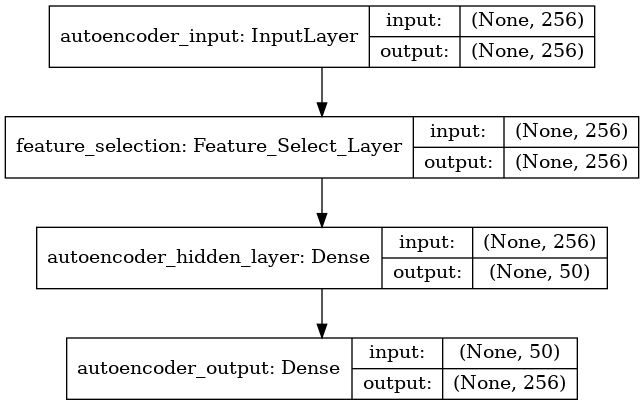

In [7]:
Ide_AE,\
latent_encoder_score_Ide_AE=Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                                                 p_encoding_dim=50,\
                                                 p_learning_rate= 1E-2,\
                                                 p_l1_lambda=l1_lambda)

file_name="./log/AgnoSS.png"
plot_model(Ide_AE, to_file=file_name,show_shapes=True)

In [8]:
model_checkpoint=ModelCheckpoint('./log_weights/Ide_AE_weights.{epoch:04d}.hdf5',period=100,save_weights_only=True,verbose=1)
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(Ide_AE.layers[1].get_weights()))

Ide_AE_history = Ide_AE.fit(x_train, x_train,\
                            epochs=epochs_number,\
                            batch_size=batch_size_value,\
                            shuffle=True,\
                            validation_data=(x_validate,x_validate),\
                            callbacks=[model_checkpoint])



Train on 6694 samples, validate on 744 samples
Epoch 1/1000
6694/6694 [==============================] - 1s 107us/step - loss: 39.4056 - val_loss: 0.2684
Epoch 2/1000
6694/6694 [==============================] - 0s 59us/step - loss: 0.2676 - val_loss: 0.2675
Epoch 3/1000
6694/6694 [==============================] - 0s 52us/step - loss: 0.2673 - val_loss: 0.2681
Epoch 4/1000
6694/6694 [==============================] - 0s 50us/step - loss: 0.2678 - val_loss: 0.2687
Epoch 5/1000
6694/6694 [==============================] - 0s 49us/step - loss: 0.2674 - val_loss: 0.2620
Epoch 6/1000
6694/6694 [==============================] - 0s 50us/step - loss: 0.2449 - val_loss: 0.2373
Epoch 7/1000
6694/6694 [==============================] - 0s 49us/step - loss: 0.2373 - val_loss: 0.2441
Epoch 8/1000
6694/6694 [==============================] - 0s 50us/step - loss: 0.2330 - val_loss: 0.2277
Epoch 9/1000
6694/6694 [==============================] - 0s 50us/step - loss: 0.2264 - val_loss: 0.2191
Epoc

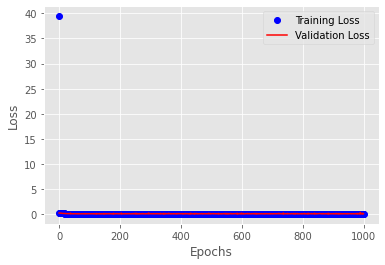

In [9]:
loss = Ide_AE_history.history['loss']
val_loss = Ide_AE_history.history['val_loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
p_data=Ide_AE.predict(x_test)
numbers=x_test.shape[0]*x_test.shape[1]

print("MSE for one-to-one map layer",np.sum(np.power(np.array(p_data)-x_test,2))/numbers)

MSE for one-to-one map layer 0.0537403065671203


---
key_number=50
---

In [11]:
key_number=50

In [12]:
key_features=F.top_k_keepWeights_1(Ide_AE.get_layer(index=1).get_weights()[0],key_number)

selected_position_list=np.where(key_features>0)[0]

# 5 Classifying

In [13]:
train_feature=C_train_x
train_label=C_train_y
test_feature=C_test_x
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9666666666666667
Testing accuracy： 0.9666666666666667


In [14]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)
print("\n\n")

(7438, 50)
(1860, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9559139784946237
Testing accuracy： 0.9559139784946237





# 6. Reconstruction loss

In [15]:
from sklearn.linear_model import LinearRegression

def mse_check(train, test):
    LR = LinearRegression(n_jobs = -1)
    LR.fit(train[0], train[1])
    MSELR = ((LR.predict(test[0]) - test[1]) ** 2).mean()
    return MSELR

In [16]:
train_feature_=np.multiply(C_train_x, key_features)
C_train_selected_x=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(C_train_selected_x.shape)

test_feature_=np.multiply(C_test_x, key_features)
C_test_selected_x=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(C_test_selected_x.shape)


train_feature_tuple=(C_train_selected_x,C_train_x)
test_feature_tuple=(C_test_selected_x,C_test_x)

reconstruction_loss=mse_check(train_feature_tuple, test_feature_tuple)
print(reconstruction_loss)

(7438, 50)
(1860, 50)
0.01654134823354442
